## Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- reading multiple files from the same folder --#
import glob

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':100000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Lag 1

## prepare data and files

In [8]:
# lag time to analyse
lag = 1
#load files
hist_files = sorted( glob.glob("test_different_seeds/lag"+str(lag)+"/bias1_seed*/COLVAR") )
print(hist_files)
#-- prepare colors for plotting --#
cmap = plt.get_cmap('fessa')
color = [cmap(i) for i in np.linspace(0, 1, len(hist_files))]
alpha = [i for i in np.linspace(1,.1,len(hist_files))]

['test_different_seeds/lag1/bias1_seed1462/COLVAR', 'test_different_seeds/lag1/bias1_seed151/COLVAR', 'test_different_seeds/lag1/bias1_seed1865/COLVAR', 'test_different_seeds/lag1/bias1_seed1986/COLVAR', 'test_different_seeds/lag1/bias1_seed2277/COLVAR', 'test_different_seeds/lag1/bias1_seed3232/COLVAR', 'test_different_seeds/lag1/bias1_seed35/COLVAR', 'test_different_seeds/lag1/bias1_seed38/COLVAR', 'test_different_seeds/lag1/bias1_seed3892/COLVAR', 'test_different_seeds/lag1/bias1_seed4045/COLVAR', 'test_different_seeds/lag1/bias1_seed4939/COLVAR', 'test_different_seeds/lag1/bias1_seed500/COLVAR']


## trajectories in $\psi$ and $\phi$ space 

Text(0, 0.5, '$y$')

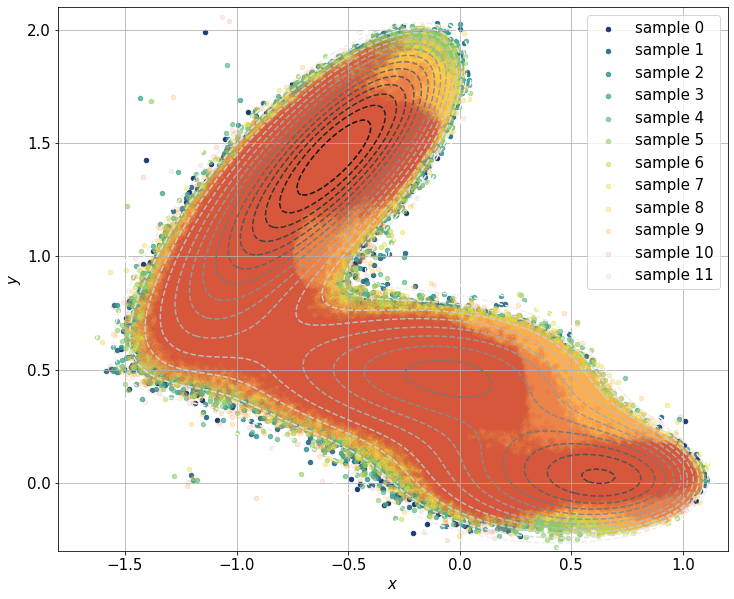

In [9]:
# trajectories 
fig,ax = plt.subplots(1,1,figsize=(12,10))
for i, file in enumerate(hist_files):
    load_dataframe(file).plot.scatter(y="p.y",x="p.x",ax=ax,label="sample "+str(i),color=color[i],alpha=alpha[i])
# plot fes isolines
#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)
bounds = np.arange(0, 16, 1.)
c = ax.contour(X, Y, Z, bounds , cmap="gray",shading='auto', linewidth=5, linestyles="dashed")
ax.grid()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    

## Histograms, Mean and Standard deviation

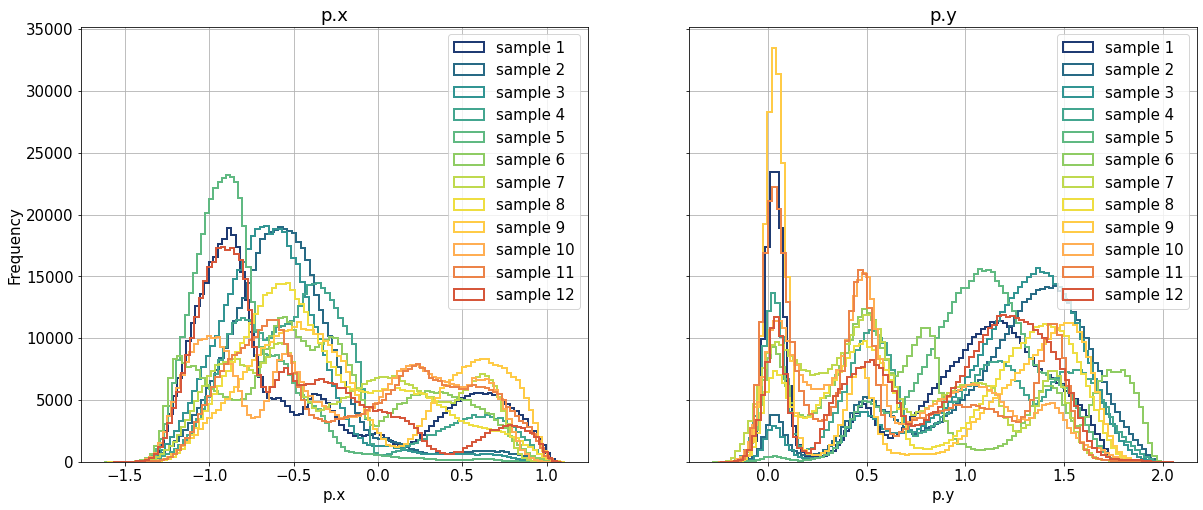

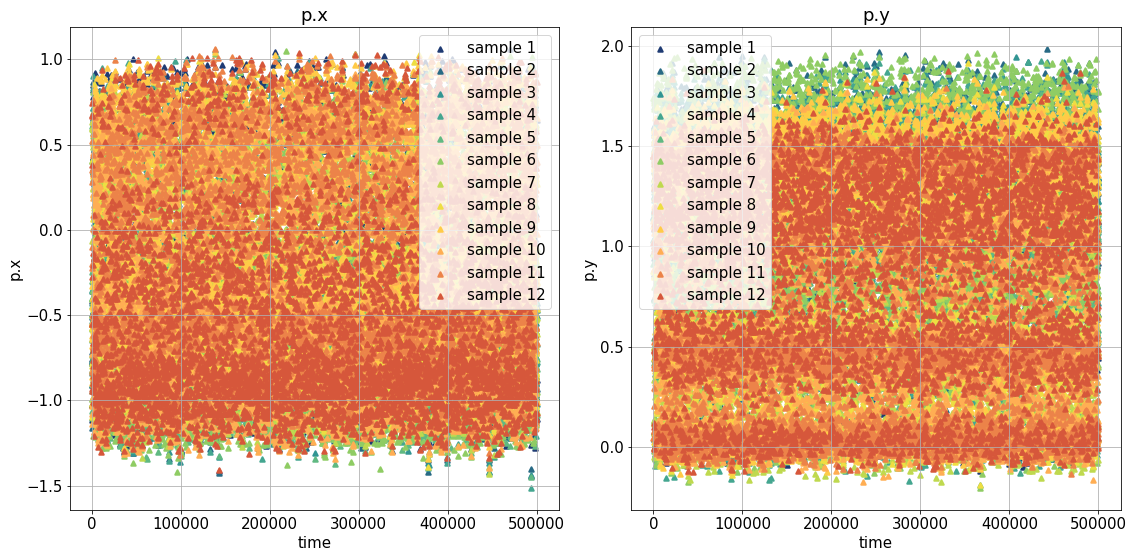

In [10]:
fig1,axs1 = plt.subplots(1,2,figsize=(20,8),sharey=True)
fig2,axs2 = plt.subplots(1,2,figsize=(16,8))#,sharey=True)
k=0
# bins for histograms
bins = 100
for file in hist_files:
    data = load_dataframe(file)
    descriptors_names = data.filter(regex='^p').columns.values

    # histograms
    for ax,desc in zip(axs1.flatten(),descriptors_names):
        data[desc].plot.hist(bins=bins,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=False,color=color[k],label="sample "+str(k+1))
        #data[desc].plot.hist(bins=50,alpha=alpha[k],ax=ax,grid=True,color=color[k],density=True,label="sample "+str(k+1))
        ax.set_title(desc)
        ax.set_xlabel(desc)
        ax.legend()

    # scatter plot
    for ax,desc in zip(axs2.flatten(),descriptors_names):
        data[::100].plot.scatter(x="time",y=desc,alpha=1,ax=ax,grid=True,linewidth=2,marker="^",label="sample "+str(k+1),color=color[k])
        #data[::100].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color=color[k])
        ax.set_title(desc)
        ax.set_ylabel(desc)
        ax.legend()
    k+=1

    plt.tight_layout()

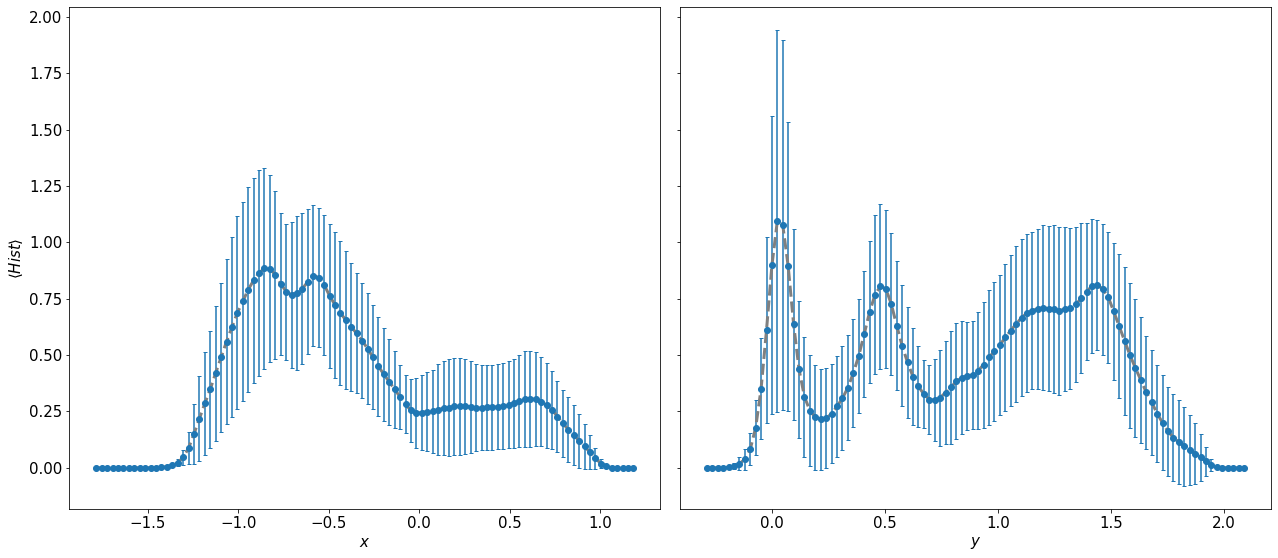

In [13]:
# edges to plot histograms
Range = ((-1.8,1.2),(-0.3,2.1))
edges_x = np.histogram(load_dataframe(hist_files[0]),bins=bins,range=Range[0])[1]
x = (edges_x[:-1]+edges_x[1:])/2
edges_y = np.histogram(load_dataframe(hist_files[0]),bins=bins,range=Range[1])[1]
y = (edges_y[:-1]+edges_y[1:])/2
# axes for plot
fig, axs = plt.subplots(1,2,figsize=(18,8),sharey=True)

for j,ax in enumerate(axs):
    #-- faster way using pandas --#
    df = pd.concat( ( pd.Series(np.histogram(load_dataframe(file)[descriptors_names[j]],bins=bins,range=Range[j],density=True)[0]) for file in hist_files),ignore_index=True,axis='columns')
    df2 = pd.concat( (df.mean(axis=1),df.std(axis=1)), ignore_index=True,axis='columns') 
    df2.columns = ["mean","std"]
    if j==0:
        df2[descriptors_names[j]] = x
    else:
        df2[descriptors_names[j]] = y
    ax.errorbar(df2[descriptors_names[j]], df2["mean"], df2["std"], fmt='o', capsize=2, capthick=1)
    ax.plot(df2[descriptors_names[j]],df2["mean"].to_numpy(),color="gray",linewidth=3,linestyle="dashed")
axs[0].set_xlabel(r"$x$")
axs[1].set_xlabel(r"$y$")
axs[0].set_ylabel(r"$\langle Hist \rangle$")
plt.tight_layout()

## Estimation of the Free Energy

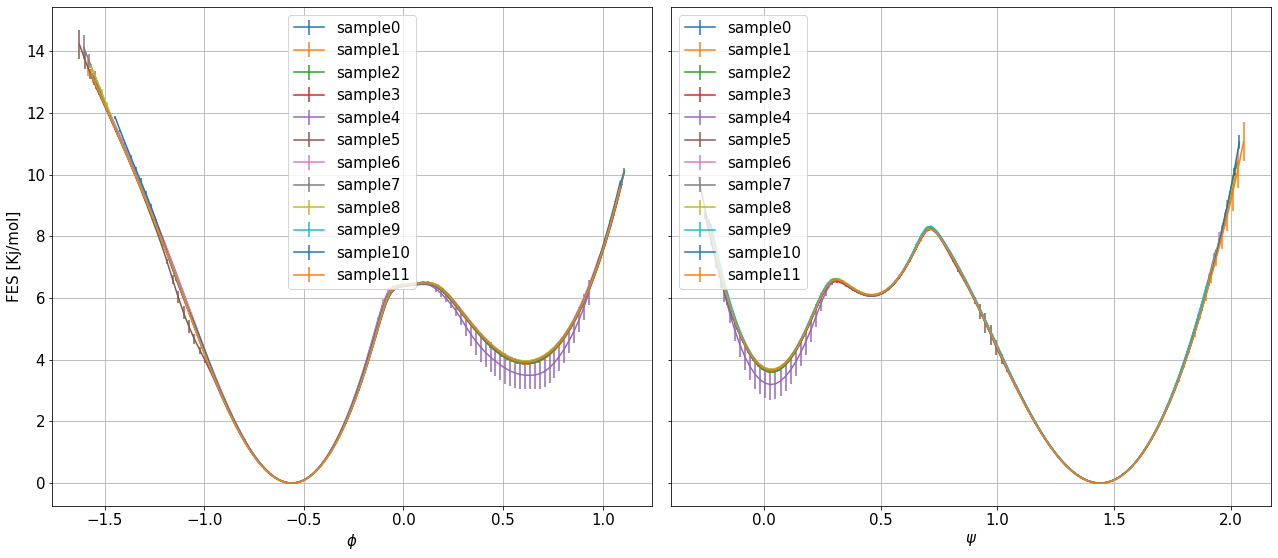

In [14]:
#-- estimation of Free Energy Surface --#
fig, axs = plt.subplots(1,2,figsize=(18,8),sharey=True)
samples = ["sample"+str(i) for i in range(len(hist_files))]
for file in hist_files:
    s = load_dataframe(file).filter(regex="^p").to_numpy()
    logweight = np.transpose( load_dataframe(file).filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]
    logweight = logweight - np.max(logweight)

    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            kbt=sim_parameters["temp"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = axs[i])

for i in range(2):
    axs[i].legend(samples)   
    axs[i].grid()
    axs[i].set_ylabel("")
axs[0].set_ylabel("FES [Kj/mol]")
axs[0].set_xlabel(r"$\phi$")
axs[1].set_xlabel(r"$\psi$")
plt.tight_layout()

## different trainings  
Are the new cvs able to distinguish the TS ?

In [15]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#
models = []
datas = []

In [17]:
torch.manual_seed(21)
for i,file in enumerate(hist_files):
    model,data,logweight,X = training(sim_parameters["temp"],file,train_parameters)
    #-- move the model back to cpu for convenience --# 
    model.to('cpu')
    # append model
    models.append(model)
    # save cvs values and append dataframe
    data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
    data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
    datas.append(data)

no weights
Time-lagged pairs:	 499998
Training data:		 349998
Validation data:	 150000
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
257   -1.797      -1.801      0.979  0.818  
no weights
Time-lagged pairs:	 499998
Training data:		 349998
Validation data:	 150000
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
193   -1.801      -1.812      0.937  0.863  
no weights
Time-lagged pairs:	 499998
Training data:		 349998
Validation data:	 150000
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.613      -1.609      0.929  0.684  
INFO: Early stopping
781   -1.653      -1.648      0.955  0.698  
no weights
Time-lagged pairs:	 499998
Training data:		 349998
Validation data:	 150000
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
454   -1.916      -1.916      0.974  0.942  
no weights
Time-lagged pairs:	 499998
Training data:		 349998
Validation data:	 150000
INFO: Early stopping
Epoch Train Los

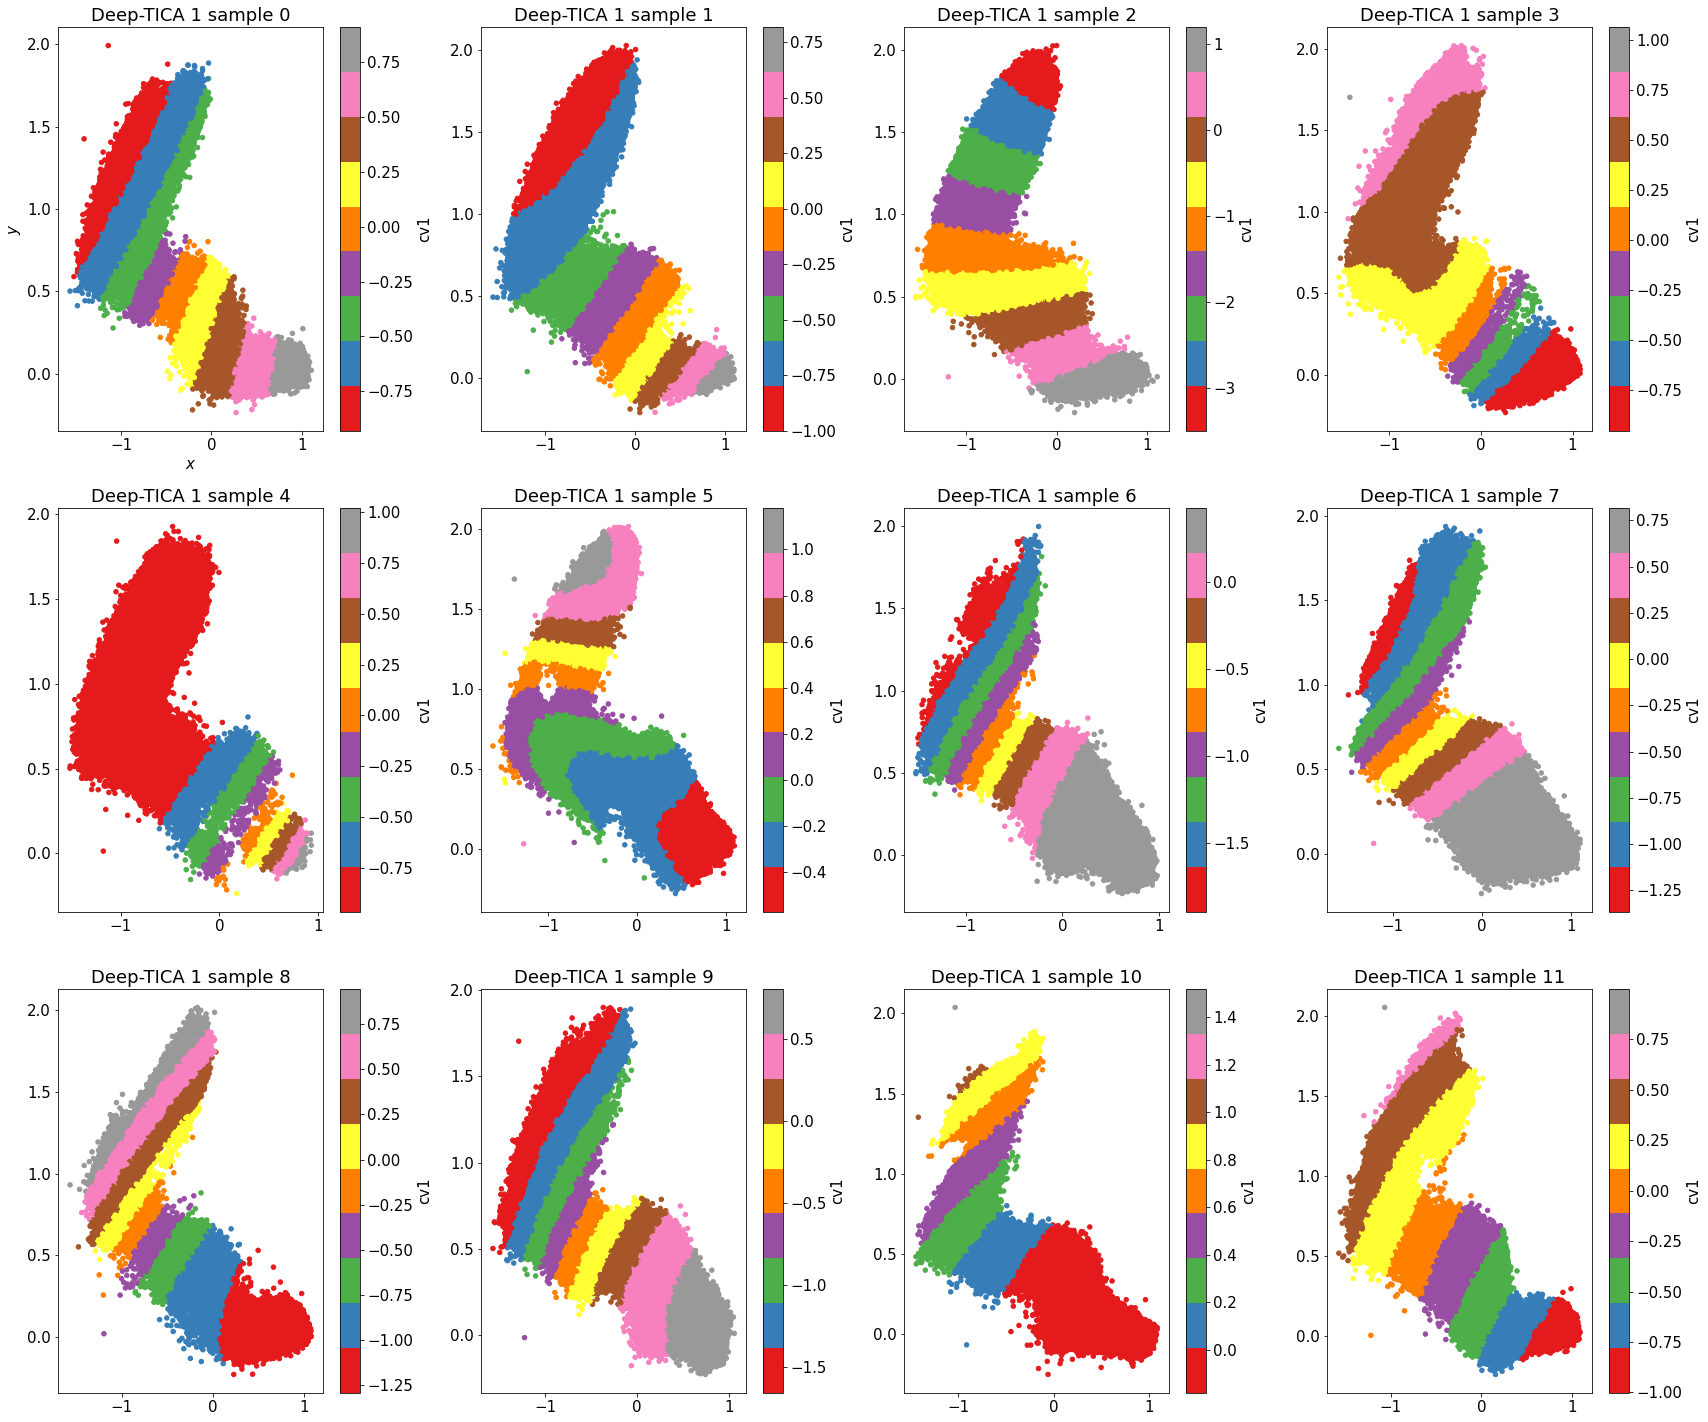

In [18]:
#-- cv1 --#
fig,axs = plt.subplots(3,4,figsize=(24,20))

for i,ax in enumerate(fig.axes):
    datas[i].plot.scatter(y="p.y",x="p.x",c="cv1",cmap="Set1",ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title('Deep-TICA 1 sample '+str(i))
axs[0][0].set_ylabel(r"$y$")
axs[0][0].set_xlabel(r"$x$")
plt.tight_layout()

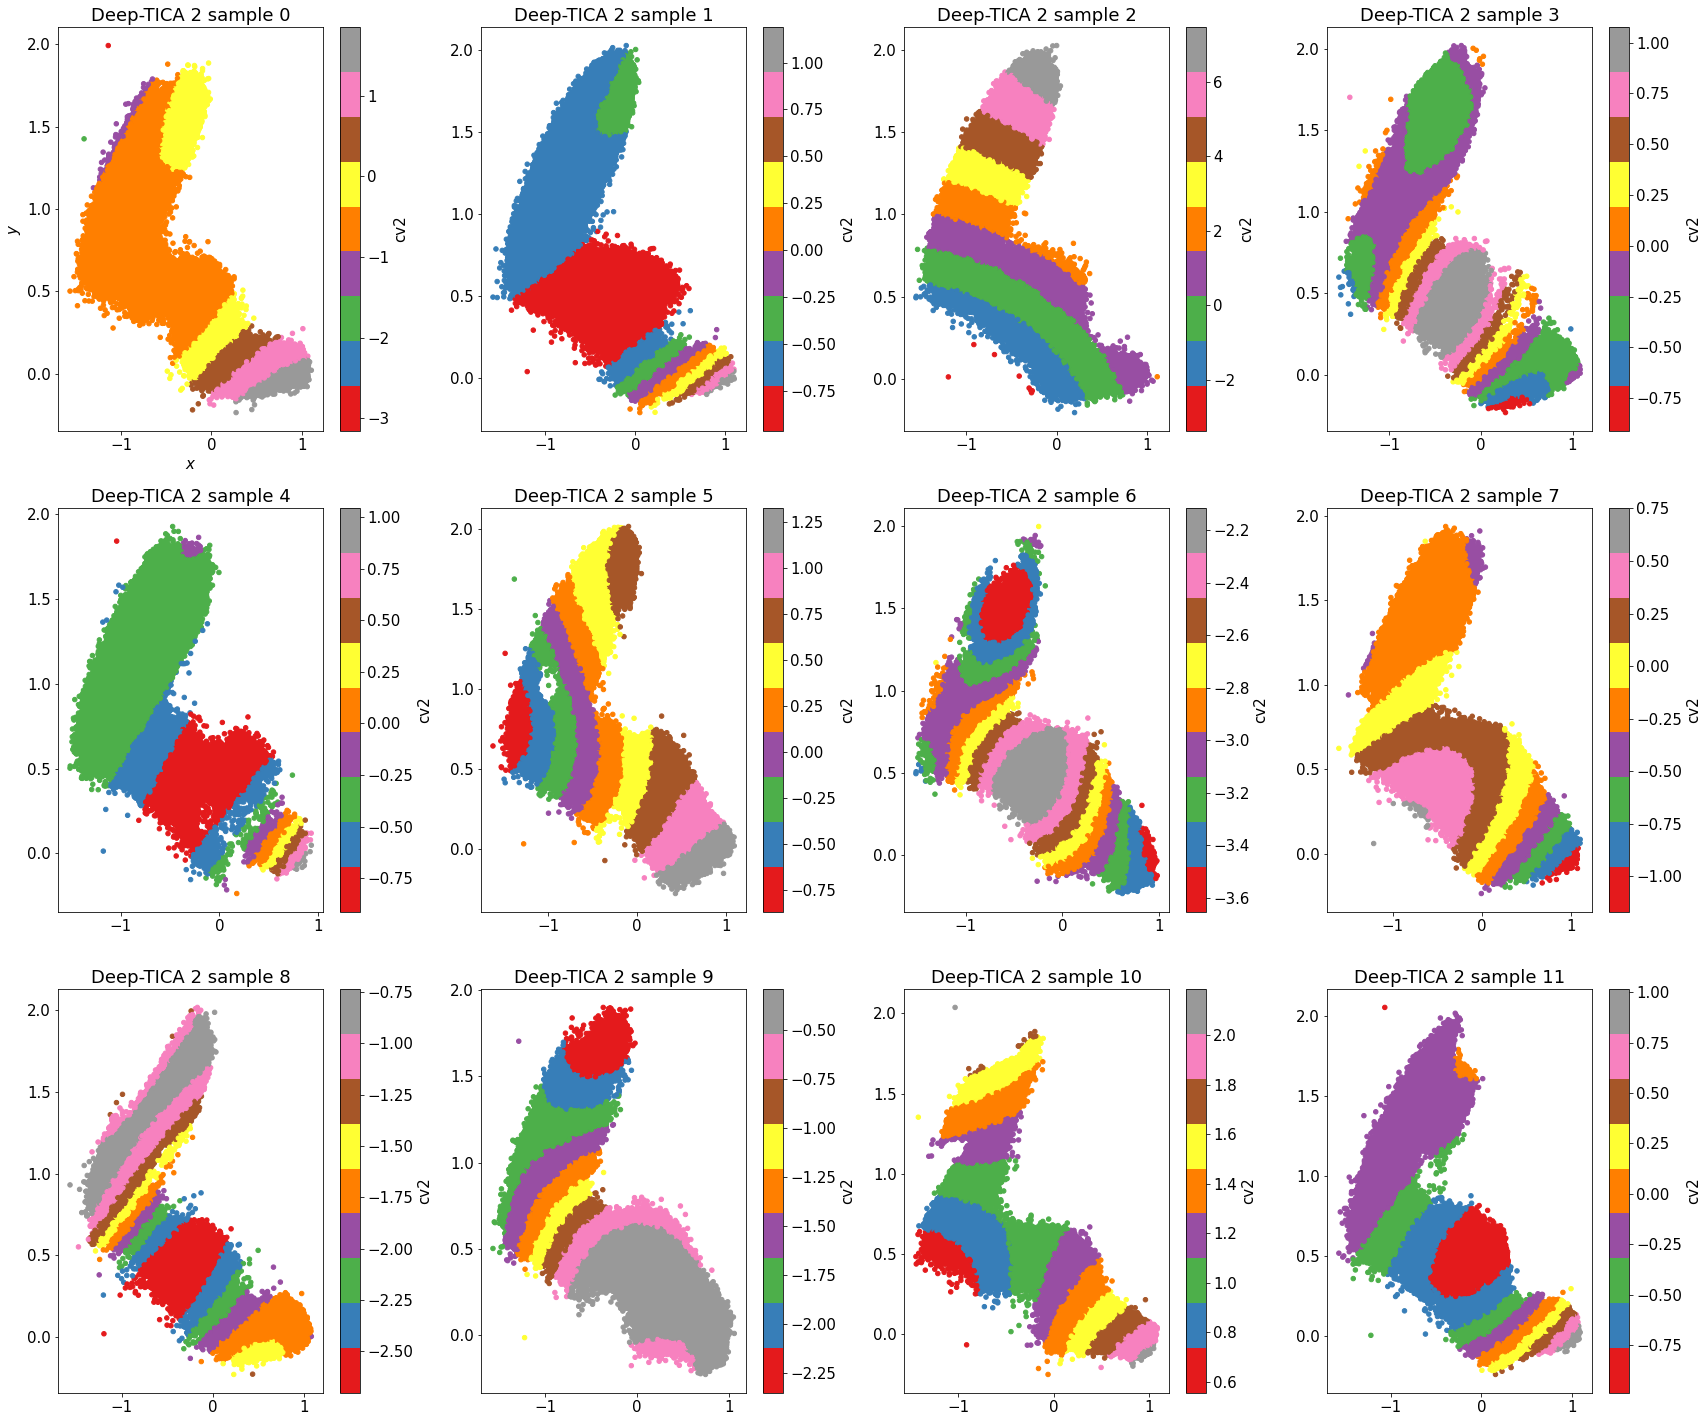

In [19]:
#-- cv2 --#
fig,axs = plt.subplots(3,4,figsize=(24,20))

for i,ax in enumerate(fig.axes):
    datas[i].plot.scatter(y="p.y",x="p.x",c="cv2",cmap="Set1",ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title('Deep-TICA 2 sample '+str(i))
axs[0][0].set_ylabel(r"$y$")
axs[0][0].set_xlabel(r"$x$")
plt.tight_layout()